In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pf
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#Creates Pandas-Profiling reports

#train_report = pf.ProfileReport(train)
#train_report.to_file(output_file="Training_Data_Report.html")

#test_report = pf.ProfileReport(test)
#test_report.to_file(output_file="Testing_Data_Report.html")

In [4]:
train = train.drop(columns = ['PassengerId','Cabin', 'Name','Ticket'])
test = test.drop(columns=['Cabin', 'Name','Ticket'])

In [5]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [6]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [7]:
train_num = train[['Age', 'Fare']]
train_cat = train[['Survived','Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]

test_num = test[['Age', 'Fare']]
test_cat = test[['PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]


In [8]:
imp = SimpleImputer(strategy="median")
train_imp = imp.fit_transform(train_num)
test_imp = imp.fit_transform(test_num)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_imp)
test_scaled = imp.fit_transform(test_imp)

train_num = pd.DataFrame(train_scaled, columns = train_num.columns)
test_num =  pd.DataFrame(test_scaled, columns = test_num.columns)

train_cat = pd.get_dummies(train_cat)
test_cat = pd.get_dummies(test_cat)

train_df = train_num.join(train_cat, how='outer')
test_df = test_num.join(test_cat, how='outer')


In [9]:
X = train_df.drop("Survived", axis=1)
y = train_df['Survived']

neg, pos = np.bincount(y)

total = neg + pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state = 69)

X_test = test_df.drop('PassengerId', axis=1).copy()
#y_test = test_df['PassengerId']

X_train.shape, y_train.shape, X_test.shape

((668, 10), (668,), (418, 10))

In [10]:


weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

forest = RandomForestClassifier(n_estimators = 500,
                               max_leaf_nodes=36,
                               class_weight = {0: weight_for_0, 1: weight_for_1},
                               n_jobs= -1)
forest.fit(X_train, y_train)

y_preds_RF = forest.predict(X_val)
y_probs_RF = forest.predict_proba(X_val)



In [11]:
weight_for_0

0.8114754098360656

In [12]:
weight_for_1

1.3026315789473684

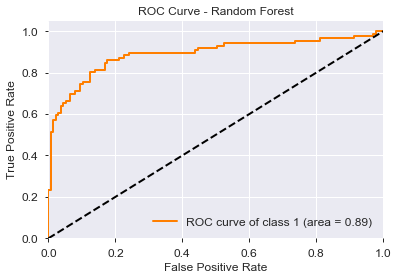

In [13]:
roc = skplt.metrics.plot_roc(y_val, y_probs_RF, plot_micro=False, 
                                plot_macro=False, classes_to_plot = [1],
                                title = "ROC Curve - Random Forest",
                                cmap="Set1", 
                                title_fontsize="large", text_fontsize="large")

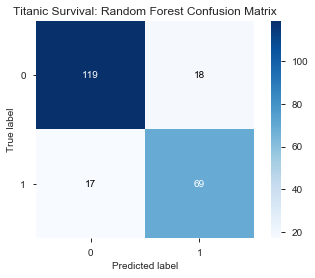

In [14]:
skplt.metrics.plot_confusion_matrix(y_val, y_preds_RF, normalize=False,
                                    title='Titanic Survival: Random Forest Confusion Matrix')

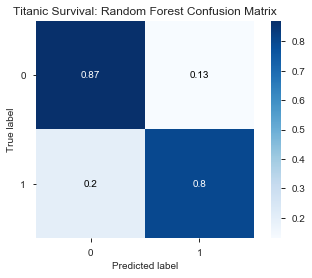

In [15]:
skplt.metrics.plot_confusion_matrix(y_val, y_preds_RF, normalize=True,
                                    title='Titanic Survival: Random Forest Confusion Matrix')


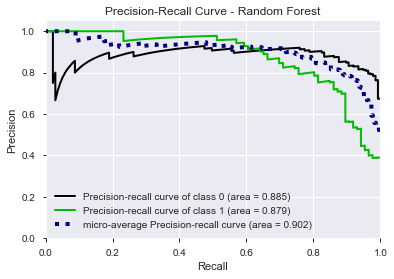

In [16]:
skplt.metrics.plot_precision_recall(y_val, y_probs_RF, title = "Precision-Recall Curve - Random Forest")

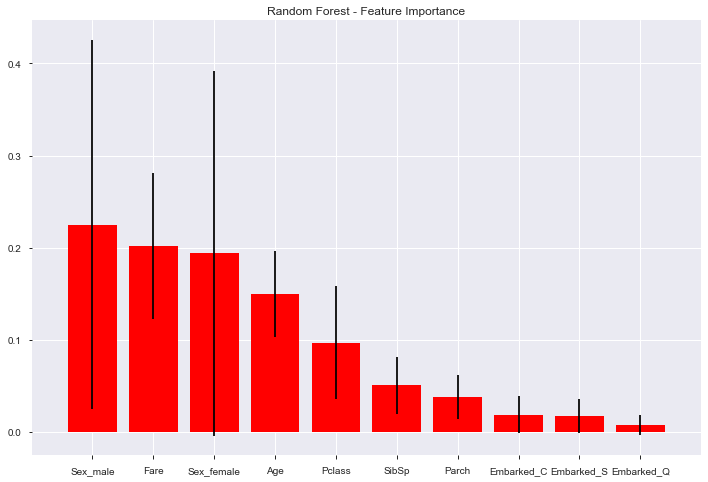

In [17]:
skplt.estimators.plot_feature_importances(forest, feature_names = X_train.columns, figsize=(12,8),
                                          title='Random Forest - Feature Importance')

In [18]:
# Get submission for Random Forest
y_RF_preds = forest.predict(X_test)
RF_submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_RF_preds
})

RF_submission.to_csv("RandomForestSubmission.csv", index=False)

In [19]:
#%% XGBoost

D_matrix = xgb.DMatrix(data = X, label = y)



# Instantiate XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic', 
                                   eval_metric = "error", 
                                   colsample_byytree = 0.3, 
                                   scale_pos_weight = weight_for_1,
                                   learning_rate = 0.001, 
                                   max_depth = 6, 
                                   alpha = 10, 
                                   n_estimators = 500
                                  )
                                

xgb_classifier.fit(X_train, y_train)
y_probs_xgb = xgb_classifier.predict_proba(X_val)
y_preds_xgb = xgb_classifier.predict(X_val)

params = {"objective":"binary:logistic", "colsample_bytree": 0.3,
               "learning_rate": 0.01, "max_depth": 6, "alpha": 10}

cross_validation_results = xgb.cv(dtrain = D_matrix, params = params, nfold = 3,
                          num_boost_round = 50, early_stopping_rounds = 1,
                          metrics = "auc", as_pandas = True)


C:\ProgramData\Miniconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Miniconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [20]:
cross_validation_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.796315,0.006394,0.780382,0.002826
1,0.831868,0.015161,0.814587,0.011189
2,0.836815,0.018253,0.819802,0.016242


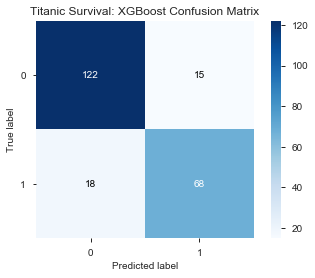

In [21]:
skplt.metrics.plot_confusion_matrix(y_val, y_preds_xgb, normalize=False,
                                    title='Titanic Survival: XGBoost Confusion Matrix')

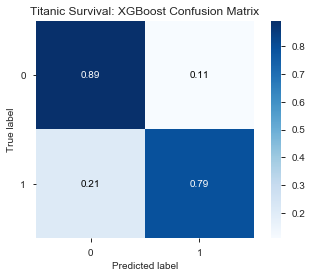

In [22]:
skplt.metrics.plot_confusion_matrix(y_val, y_preds_xgb, normalize=True,
                                    title='Titanic Survival: XGBoost Confusion Matrix')

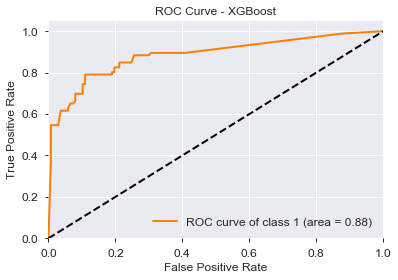

In [23]:
roc_XGB = skplt.metrics.plot_roc(y_val, y_probs_xgb, plot_micro=False, 
                                plot_macro=False, classes_to_plot = [1],
                                title = "ROC Curve - XGBoost",
                                cmap="Set1", 
                                title_fontsize="large", text_fontsize="large")

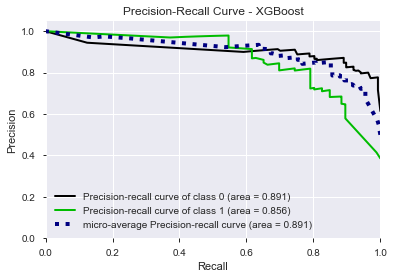

In [24]:
skplt.metrics.plot_precision_recall(y_val, y_probs_xgb,title = "Precision-Recall Curve - XGBoost")

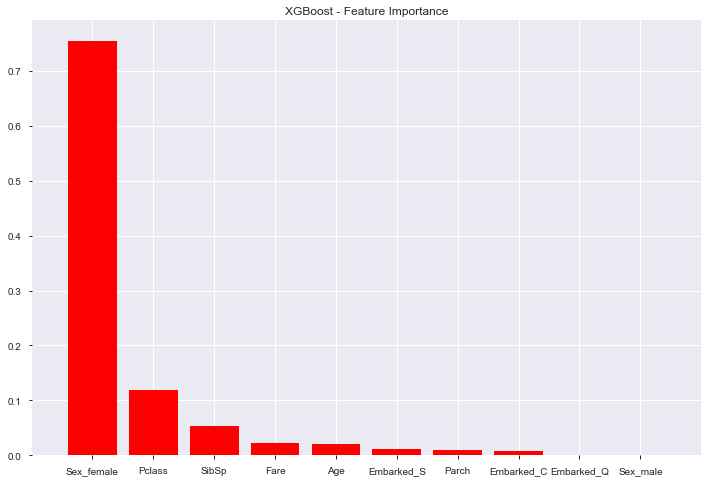

In [25]:
skplt.estimators.plot_feature_importances(xgb_classifier, feature_names = X_train.columns, figsize=(12,8),
                                          title='XGBoost - Feature Importance')

In [26]:
xgb_y_preds = xgb_classifier.predict(X_test)


XGB_submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": xgb_y_preds
    })

XGB_submission.to_csv("XGBoostSubmission.csv", index=False)